In [1]:
cd Actor-Critic-Methods-Paper-To-Code-master/DDPG/

/Users/amintabrizian/Documents/Apply/TrajectoryPlanning-/Actor-Critic-Methods-Paper-To-Code-master/DDPG


In [31]:
from gym import Env
from gym.spaces import Discrete, Box, Tuple
import numpy as np
import random
import matplotlib.pyplot as plt
from ddpg_torch import Agent
from utils import plot_learning_curve
import time
%matplotlib inline

In [15]:
def position_calculator(link1, link2, theta1, theta2):
    theta1rad = np.deg2rad(theta1)
    theta2rad = np.deg2rad(theta2)
    start_1 = [0, 0]
    end_1 = [start_1[0] + np.cos(theta1rad)*link1, \
             start_1[1] + np.sin(theta1rad)*link1]

    start_2 = end_1
    end_2 = [start_2[0] + np.cos(theta2rad+theta1rad)*link2, \
             start_2[1] + np.sin(theta2rad+theta1rad)*link2]
    return start_1, end_1, start_2, end_2

In [4]:
def distance(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2+(point1[1] - point2[1])**2)

In [13]:
def point_generator1(link1, link2, current_point = [0, 0], bound = 0.5):
    if (current_point == [0,0]):
      current_point= [np.abs(link1-link2), 0]
    x = np.random.uniform(low = current_point[0] - bound/2, high = current_point[0] + bound/2)
    y = np.random.uniform(low = current_point[1] - bound/2, high = current_point[1] + bound/2)
    
    while (x**2 + y**2 > (link2+link1)**2 or  x**2 + y**2 <(link2-link1)**2):
         x = np.random.uniform(low = current_point[0] - bound/2, high = current_point[0] + bound/2)
         y = np.random.uniform(low = current_point[1] - bound/2, high = current_point[1] + bound/2)
    
    return x, y

In [14]:
def point_generator2(link1, link2, current_point = [0, 0], bound = 0.5, \
                     velocity = [1, 1]):
    if (current_point == [0,0]):
      current_point= [np.abs(link1-link2), 0]
    x = velocity[0] + current_point[0]
    y = velocity[1] + current_point[1]
    
    while (x**2 + y**2 > (link2+link1)**2 or  x**2 + y**2 <(link2-link1)**2):
        velocity = np.random.uniform(low = -0.2, high= 0.2, size = 2)
        x = velocity[0] + current_point[0]
        y = velocity[1] + current_point[1]
        
    return x, y, velocity[0], velocity[1]

In [38]:
class TwoJointsEnv(Env):
    def __init__(self, link1_length, link2_length, max_episode_length):
        self.action_space = Box(low = -180, high = 180.0, shape = (2,), dtype=np.float32)
        self.observation_space = Tuple(spaces=(Box(low=0, high= 360.0, shape = (2,), dtype = np.float32), \
                                       Box(low=-(link1_length+link1_length), high = link1_length+link1_length, \
                                           shape = (2,), dtype = np.float32), \
                                       Box(low = -5, high = 5, shape = (2,), dtype = np.float32)))
        self.state = None
        self.max_length = max_episode_length
        self.episode_length = max_episode_length
        self.link1_length = link1_length
        self.link2_length = link2_length
        self.object_location = point_generator2(self.link1_length, self.link2_length, bound= 0.5)

    def step(self, action):

        temp_state = self.state[0:2].copy()
        temp_state += action
        for i, theta in enumerate(temp_state[0:2]):
          if theta > 360:
            temp_state[i] -= 360
          if theta < 0:
            temp_state[i] += 360
        self.state[0:2] = temp_state.copy()
        self.object_location = point_generator2(self.link1_length, self.link2_length, \
                                                self.object_location[0:2], 0.5, \
                                                self.object_location[2:4])
        self.state[2:6] = self.object_location
        self.episode_length -= 1 
        theta1 = self.state[0]
        theta2 = self.state[1]
        self.start_1, self.end_1, self.start_2, self.end_2 = \
                position_calculator(self.link1_length, self.link2_length, theta1, theta2)
        # Calculate reward
        reward = -distance(self.end_2, self.object_location[0:2])
        
        if self.episode_length <= 0: 
            done = True
        else:
            done = False
        

        info = {}
        
        # Return step information
        return self.state, reward, done, info

    def render(self):
        plt.plot([self.start_1[0], self.end_1[0]], \
                [self.start_1[1], self.end_1[1]] )
        plt.plot([self.start_2[0], self.end_2[0]], \
                [self.start_2[1], self.end_2[1]] , color = 'red')
        plt.scatter(self.object_location[0], self.object_location[1])
        lim = 1.2*(self.link1_length + self.link2_length)
        plt.xlim(0 - lim, 0 +lim)
        plt.ylim(0 - lim, 0 + lim)
    
    def reset(self):
        # Reset shower temperature
        self.state = np.zeros(shape=(6,), dtype = np.float32)
        # Reset shower time
        self.episode_length = self.max_length
        return self.state

In [39]:
env = TwoJointsEnv(6, 10, 150)


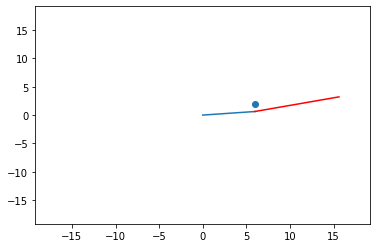

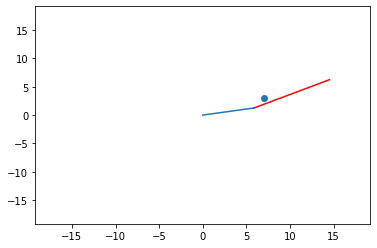

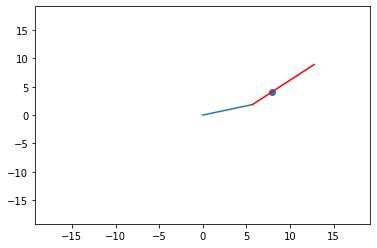

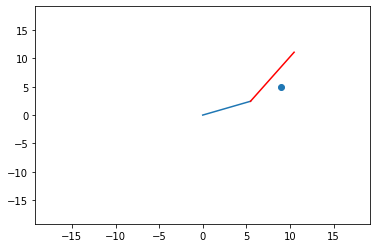

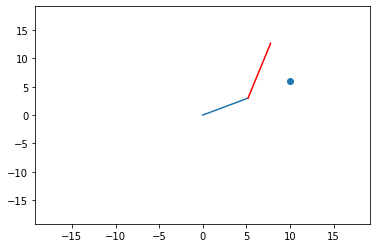

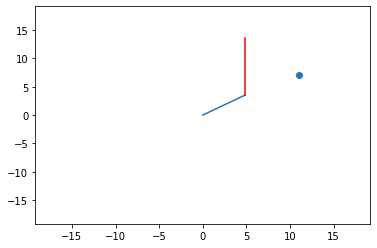

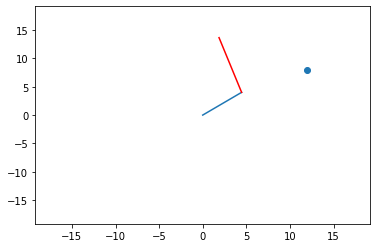

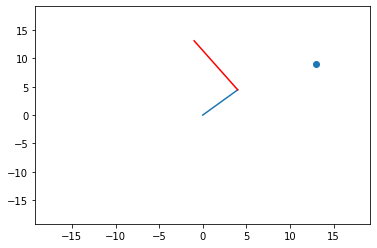

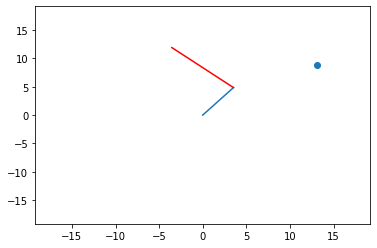

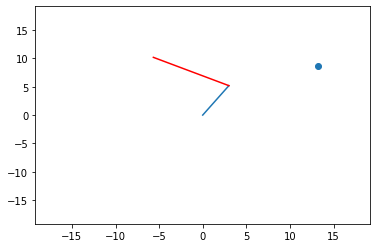

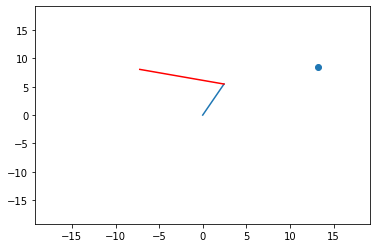

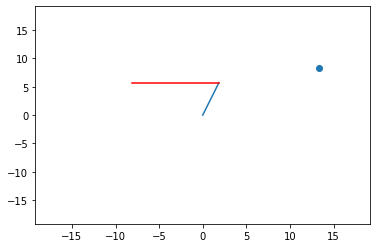

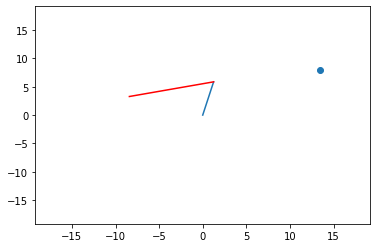

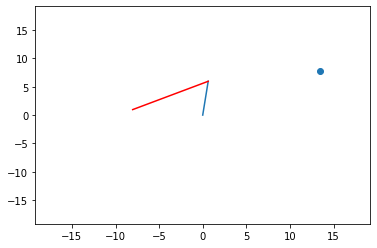

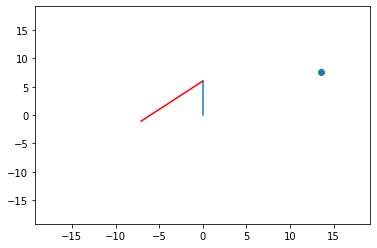

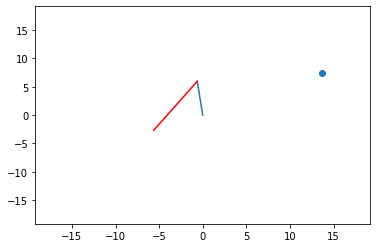

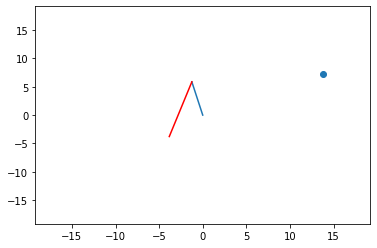

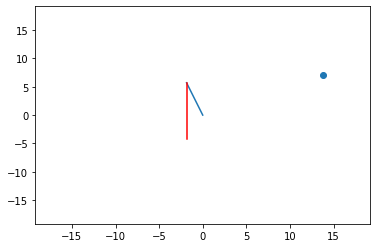

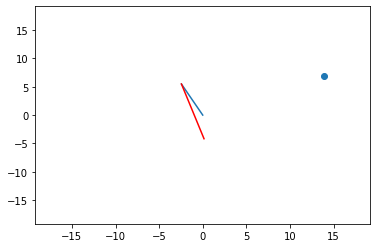

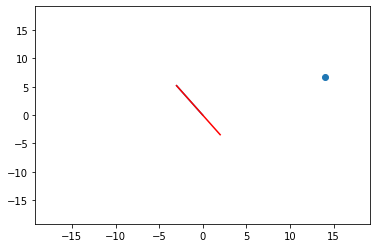

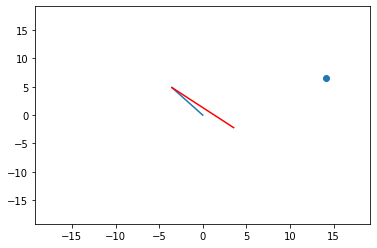

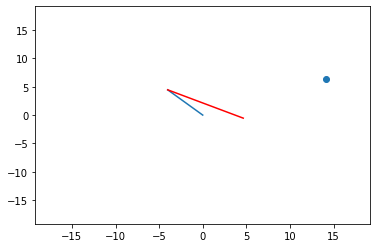

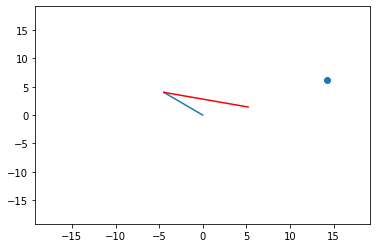

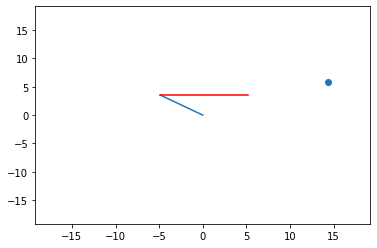

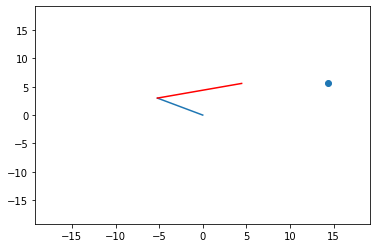

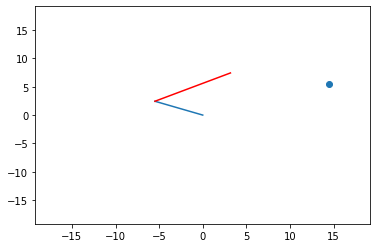

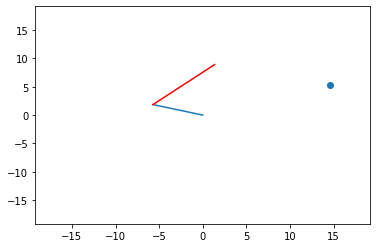

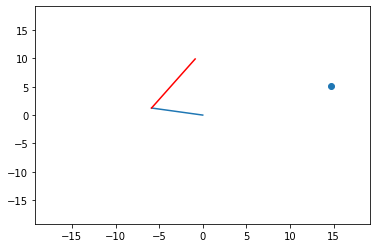

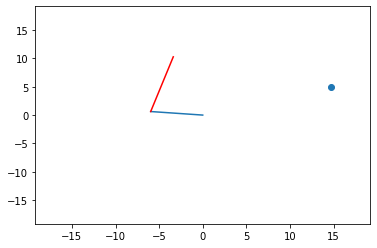

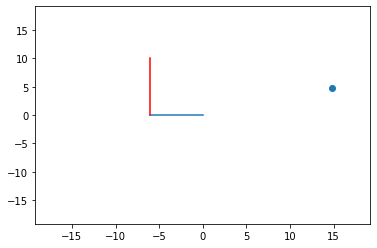

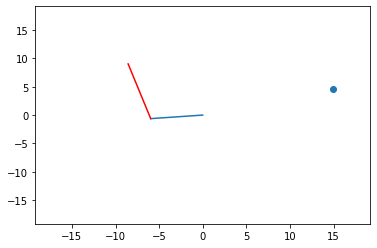

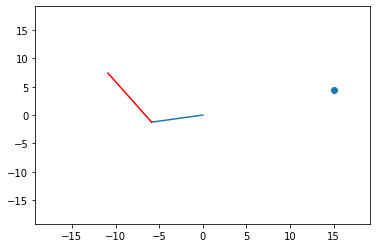

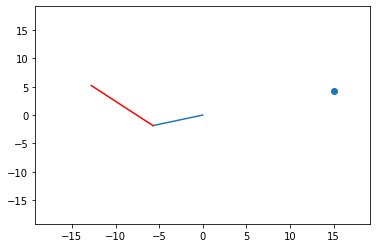

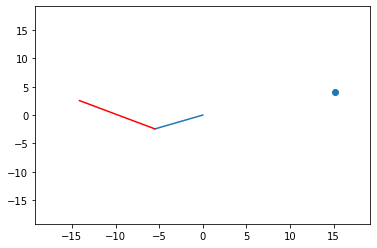

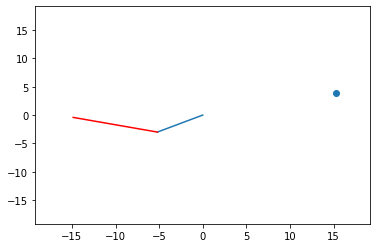

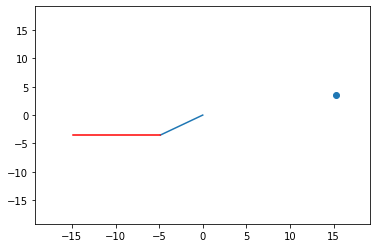

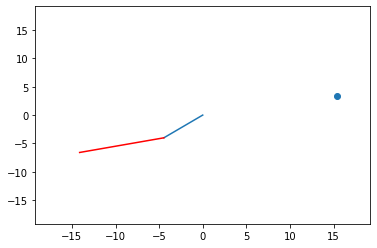

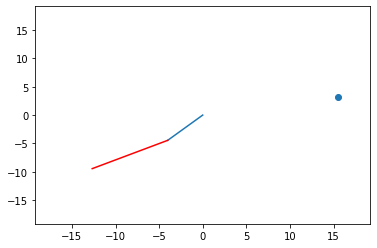

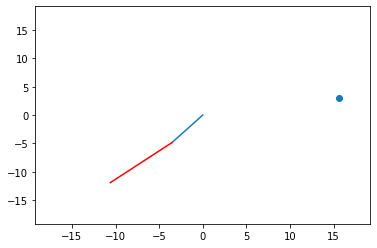

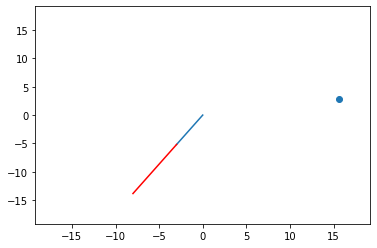

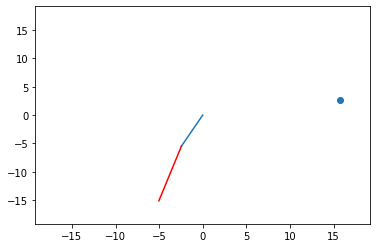

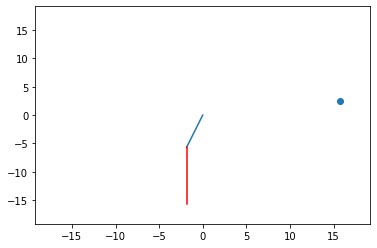

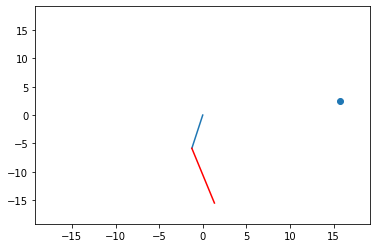

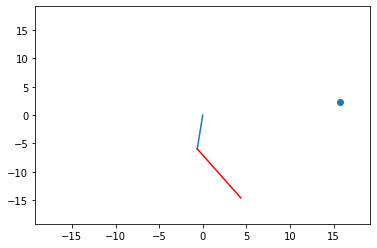

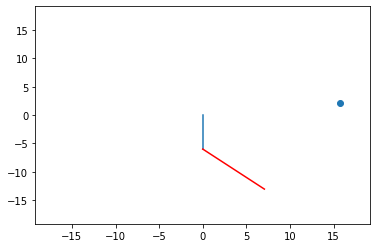

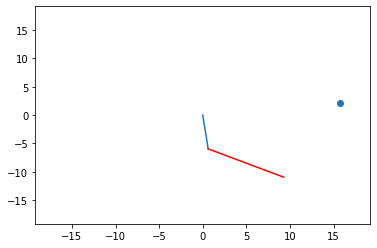

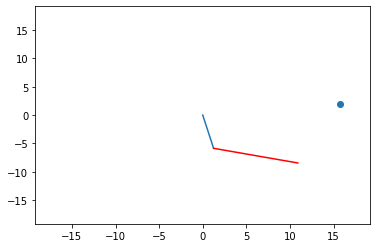

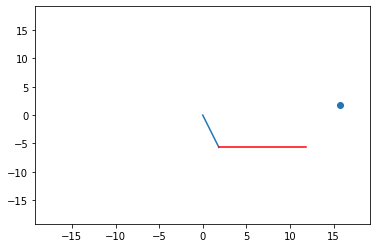

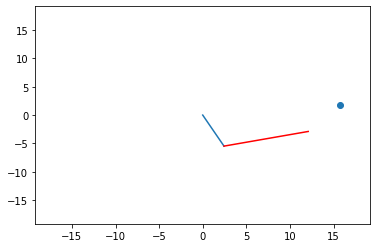

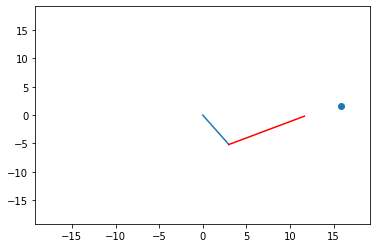

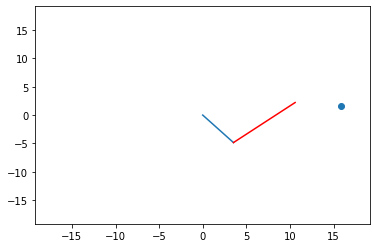

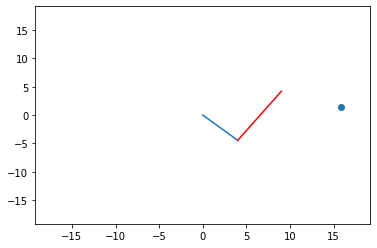

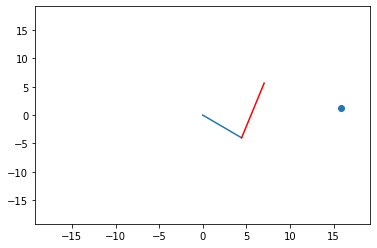

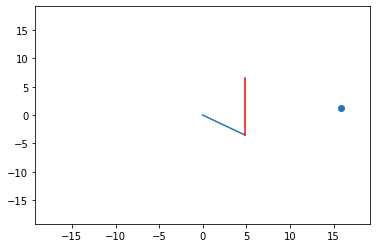

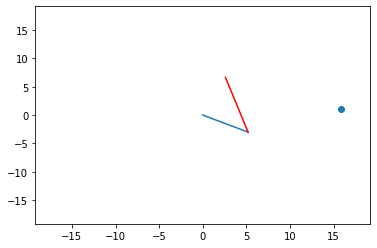

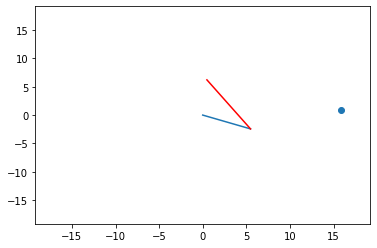

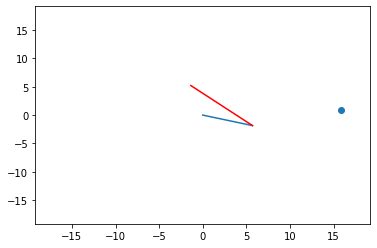

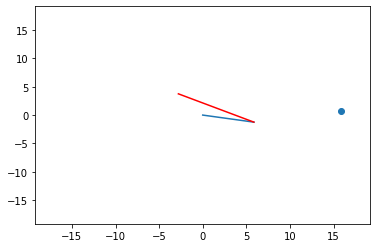

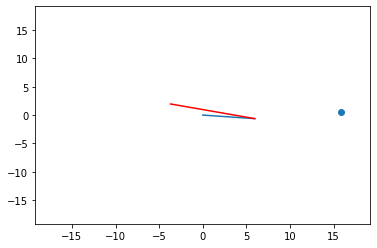

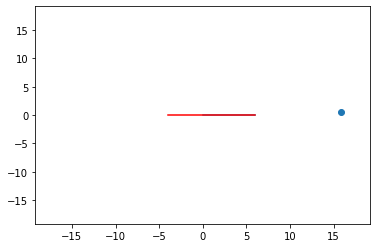

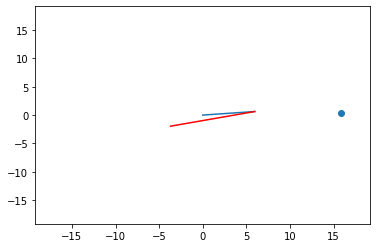

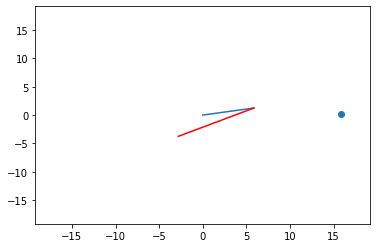

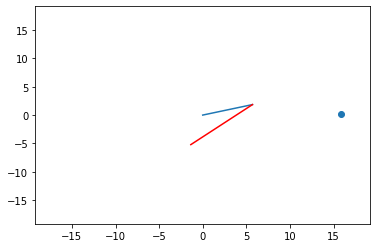

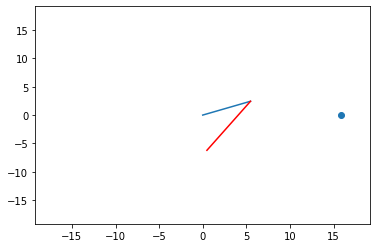

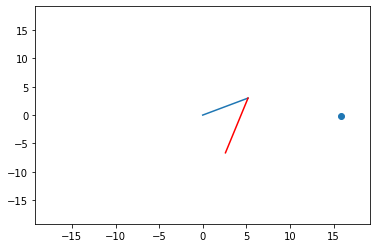

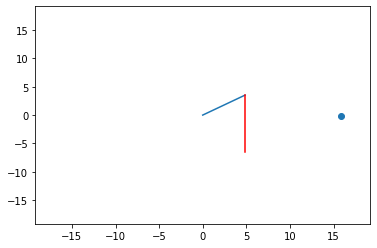

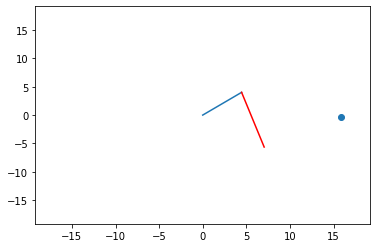

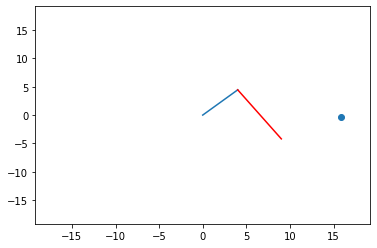

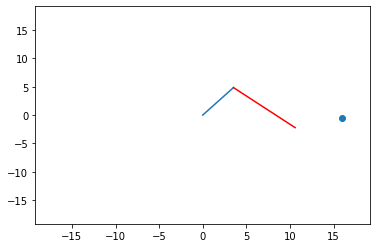

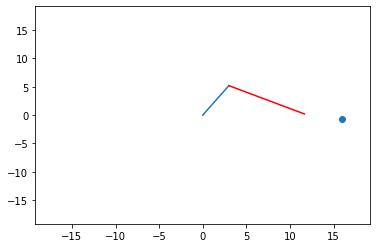

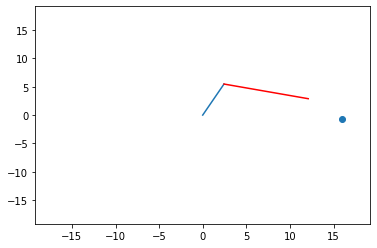

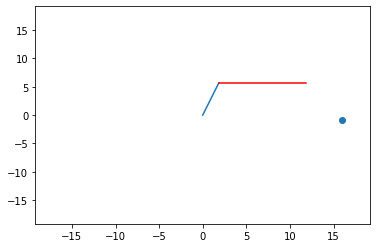

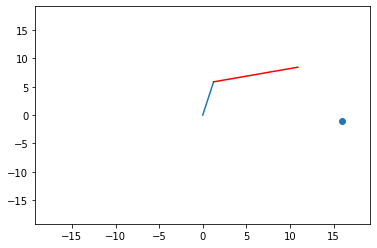

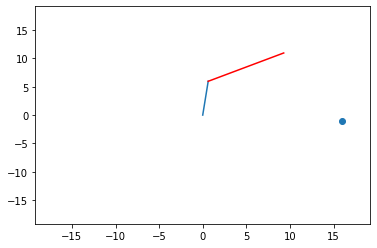

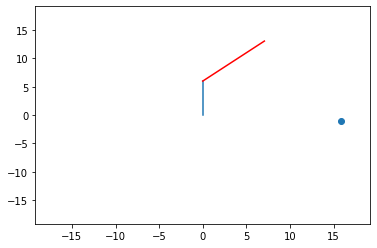

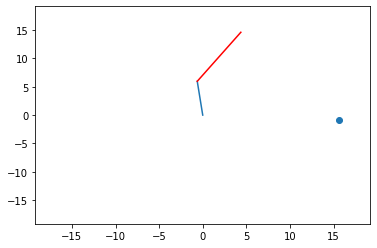

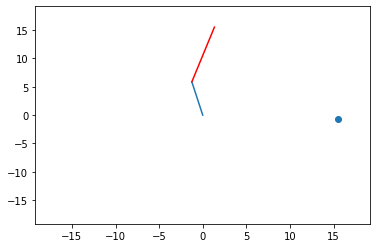

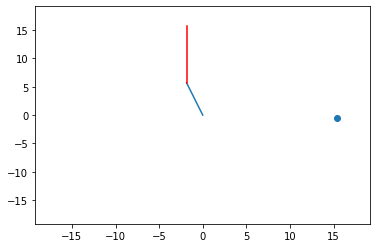

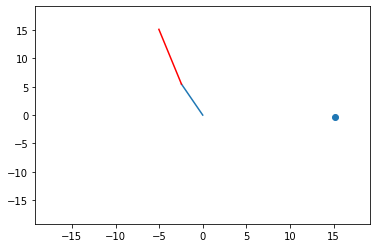

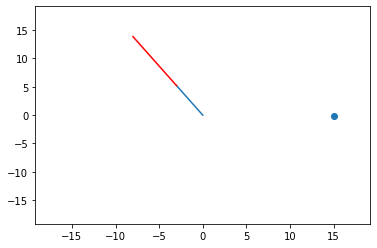

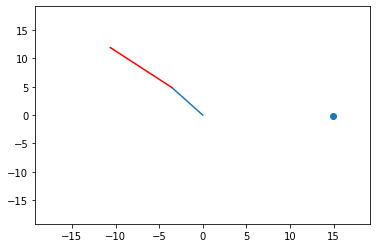

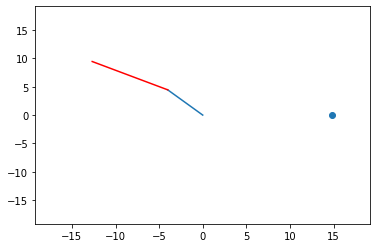

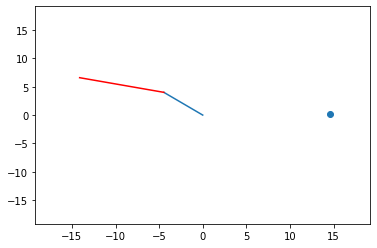

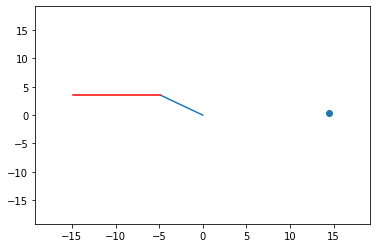

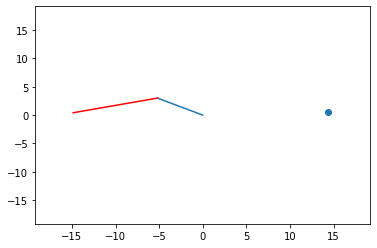

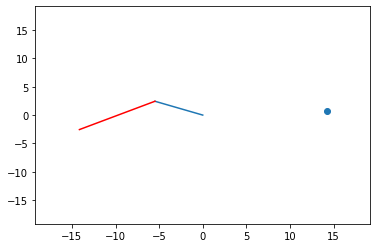

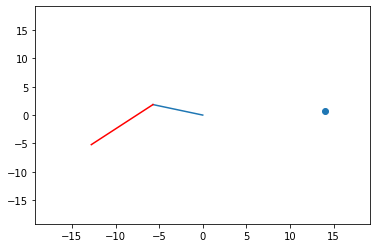

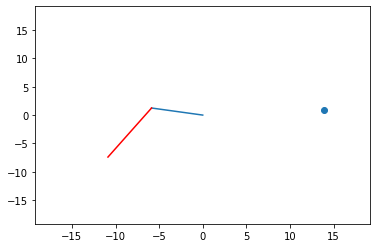

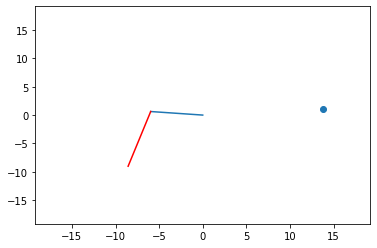

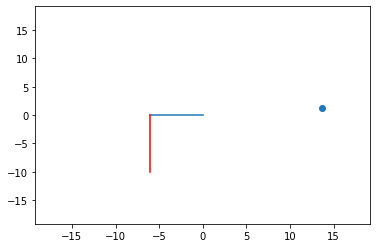

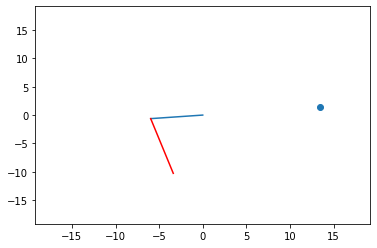

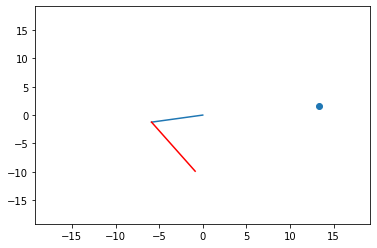

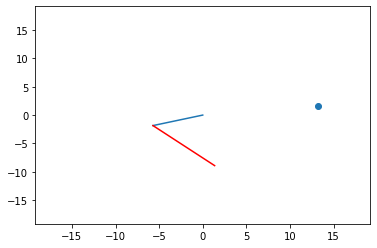

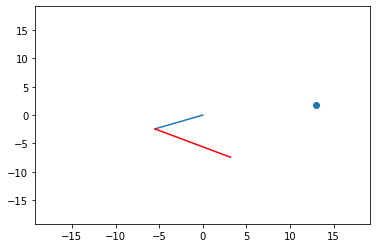

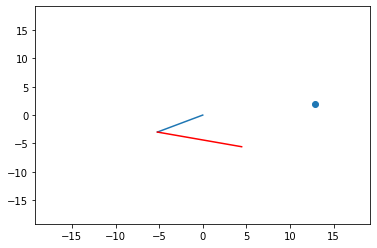

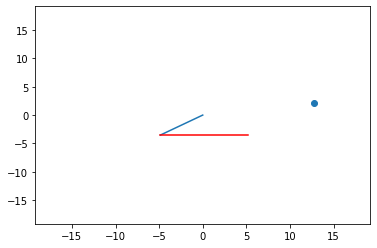

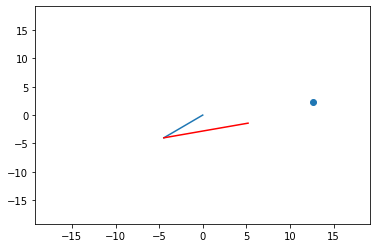

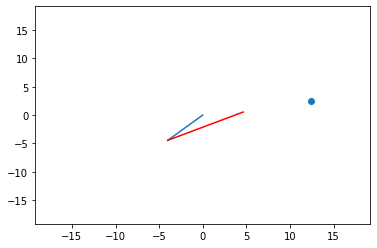

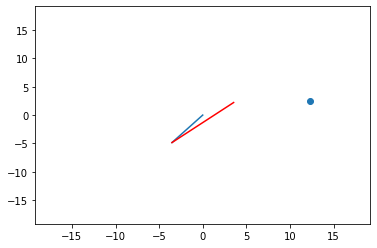

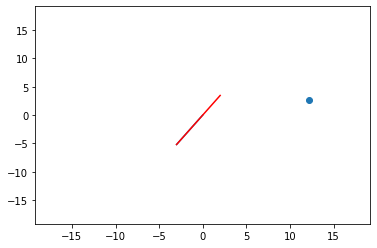

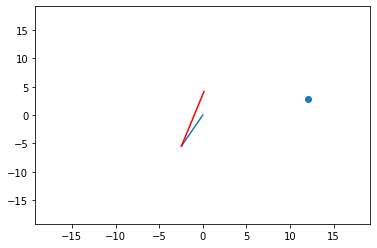

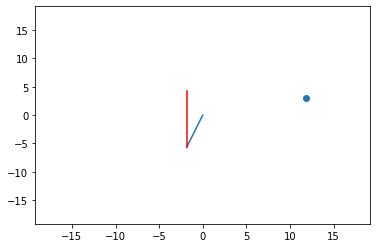

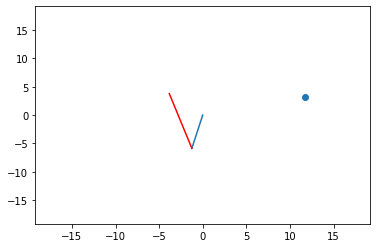

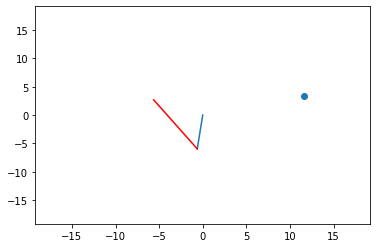

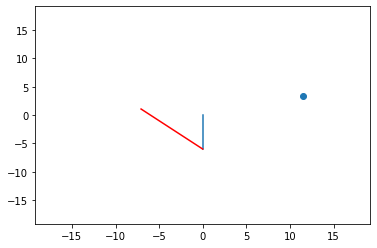

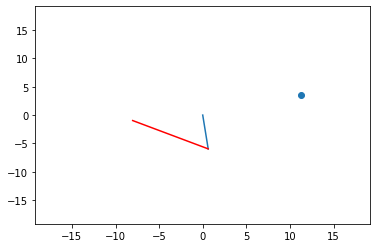

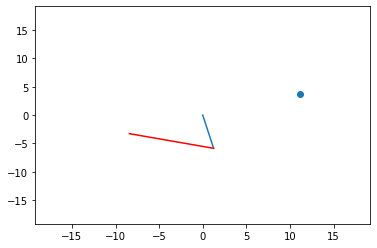

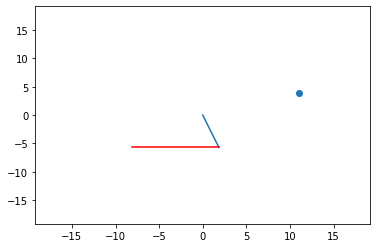

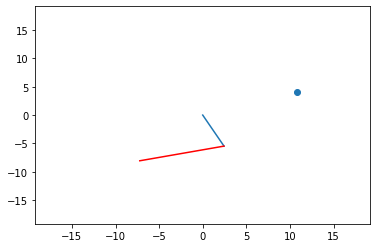

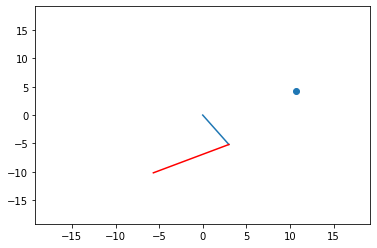

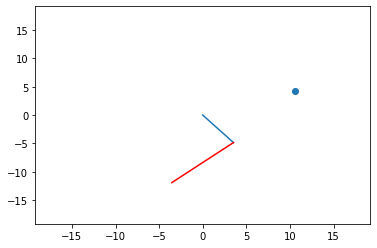

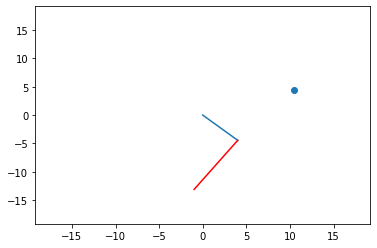

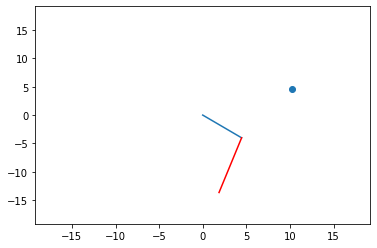

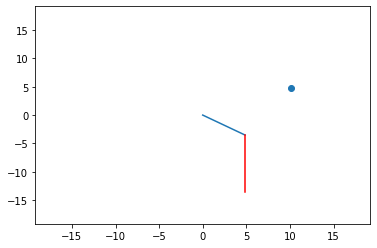

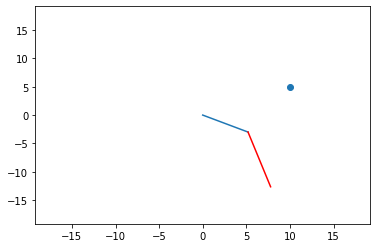

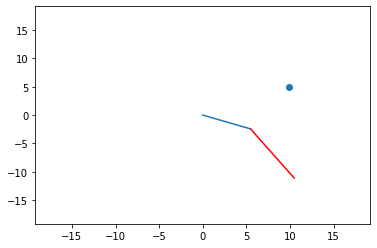

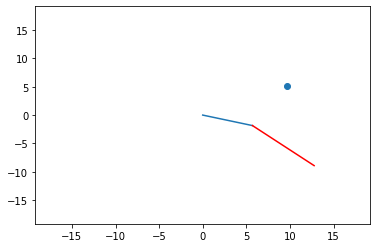

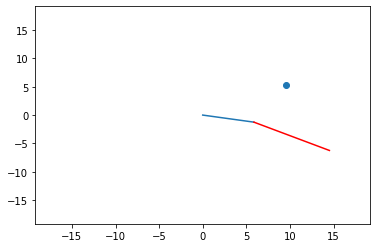

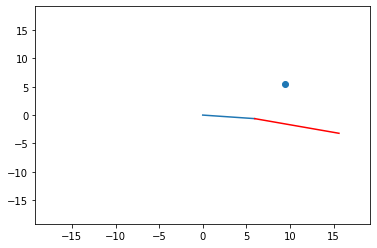

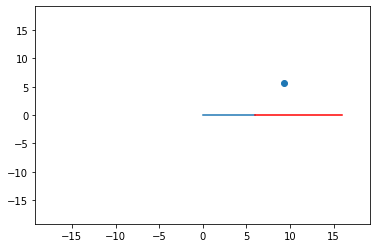

KeyboardInterrupt: 

In [40]:
%matplotlib inline
episodes = 1
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    counter = 0
    while not done:
        #env.render()
        action = [6, 9]
        n_state, reward, done, info = env.step(action)
        score+=reward
        env.render()
        plt.show()
#         print(n_state)
    print('Episode:{} Score:{}'.format(episode, score))

In [12]:
print(distance([5,0], [1,10]))

10.770329614269007


In [30]:
# env = gym.make('LunarLanderContinuous-v2')
agent = Agent(alpha=0.001, beta=0.01, 
                input_dims=(6,), tau=0.001,
                batch_size=64, fc1_dims=400, fc2_dims=300, 
                n_actions=env.action_space.shape[0])
n_games = 500
filename = 'LunarLander_alpha_' + str(agent.alpha) + '_beta_' + \
            str(agent.beta) + '_' + str(n_games) + '_games'
figure_file = filename + '.png'

best_score = env.reward_range[0]
score_history = []
for i in range(n_games):
    observation = env.reset()
    done = False
    score = 0
    agent.noise.reset()
    while not done:
        action = agent.choose_action(observation)*(env.action_space.high - env.action_space.low)
        observation_, reward, done, info = env.step(action)
        agent.remember(observation, action, reward, observation_, done)
        agent.learn()
        score += reward
        observation = observation_
    score_history.append(score)
    avg_score = np.mean(score_history[-10:])
    print('episode ', i, 'score %.1f' % score,
            'average score %.1f' % avg_score)
    if avg_score > best_score:
        best_score = avg_score
        agent.save_models()

    
x = [i+1 for i in range(n_games)]
plot_learning_curve(x, score_history, figure_file)

AssertionError: Torch not compiled with CUDA enabled

In [ ]:
agent.save_models()

... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...


In [29]:
# env = gym.make('LunarLanderContinuous-v2')
%matplotlib inline

agent = Agent(alpha=0.0001, beta=0.001, 
                input_dims=(6,), tau=0.001,
                batch_size=64, fc1_dims=400, fc2_dims=300, 
                n_actions=env.action_space.shape[0])
n_games = 5
filename = 'LunarLander_alpha_' + str(agent.alpha) + '_beta_' + \
            str(agent.beta) + '_' + str(n_games) + '_games'
figure_file = filename + '.png'

best_score = env.reward_range[0]
score_history = []
agent.load_models()
for i in range(n_games):
    observation = env.reset()
    done = False
    score = 0
    agent.noise.reset()
    counter = 0
    while not done:
        counter += 1
        action = agent.choose_action(observation)*(env.action_space.high - env.action_space.low)
        observation_, reward, done, info = env.step(action)
        print('timestep', counter)
        print(observation_, reward, done, info)
        env.render()
        plt.show()
        agent.remember(observation, action, reward, observation_, done)
        # agent.learn()
        score += reward
        observation = observation_
    score_history.append(score)
    avg_score = np.mean(score_history[-100:])

    # if avg_score > best_score:
    #     best_score = avg_score
    #     agent.save_models()

    print('episode ', i, 'score %.1f' % score,
            'average score %.1f' % avg_score)
x = [i+1 for i in range(n_games)]
plot_learning_curve(x, score_history, figure_file)

AssertionError: Torch not compiled with CUDA enabled

In [27]:
env.action_space.high - env.action_space.low

array([360., 360.], dtype=float32)

In [ ]:
env.reward_range[0]

-inf